# Perceiving Objects in Their Surroundings

## Using the Keras-RetinaNet code

### Obtaining Keras-RetinaNet

Keras RetinaNet has been compiled using Python Keras, therefore it has to installed on Python, not on R.
R can access it through the library reticulate in order the R demo to work, you first have to run the first 3 cells of the Python notebook (DSPD_0503_Object_ID.ipynb) or this R notebook won't work at all.

In [7]:
devtools::install_github("rstudio/tensorflow")
library(tensorflow)
install_tensorflow(force=TRUE)

Skipping install of 'tensorflow' from a github remote, the SHA1 (273562c0) has not changed since last install.
  Use `force = TRUE` to force installation




Installation complete.



In [4]:
URL <- "https://github.com/fizyr/keras-retinanet/archive/0.5.0.zip"
download.file(url = URL, destfile = "0.5.0.zip", mode='wb')

In [10]:
library(utils)
zipF<- "0.5.0.zip"
outDir<-"."
unzip(zipF, exdir=outDir)

In [31]:
setwd("./keras-retinanet-0.5.0")

In [34]:
response <- system("python setup.py build_ext --inplace")

[1] 0

In [37]:
response <- system("pip install .")

[1] 0

In [38]:
setwd("../")

In [8]:
library(keras)
library(reticulate)
retinanet <- import("keras_retinanet")

In [4]:
URL <- "https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5"
download.file(url = URL, destfile = "resnet50_coco_best_v2.1.0.h5", mode='wb')

### Initializing the RetinaNet model

In [9]:
model <- retinanet$models$load_model("resnet50_coco_best_v2.1.0.h5", backbone_name='resnet50')
model

Model
Model: "retinanet-bbox"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      (None, None, None 0                                   
________________________________________________________________________________
padding_conv1 (ZeroPaddin (None, None, None 0        input_1[0][0]              
________________________________________________________________________________
conv1 (Conv2D)            (None, None, None 9408     padding_conv1[0][0]        
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, None, None 256      conv1[0][0]                
________________________________________________________________________________
conv1_relu (Activation)   (None, None, None 0        bn_conv1[0][0]             
_______________________________________________________________________________

In [10]:
labels_to_names <- function(value) {
    if (value==0) {return ("person")}
    if (value==1) {return ("bicycle")}
    if (value==2) {return ("car")}
    if (value==3) {return ("motorcycle")}
    if (value==4) {return ("airplane")}
    if (value==5) {return ("bus")}
    if (value==6) {return ("train")}
    if (value==7) {return ("truck")}
    if (value==8) {return ("boat")}
    if (value==9) {return ("traffic light")}
    if (value==10) {return ("fire hydrant")}
    if (value==11) {return ("stop sign")}
    if (value==12 ){return ("parking meter")}
    if (value==25) {return ("umbrella")}
    return("unknown")
}

### Downloading the test image

In [41]:
URL <- "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Woman_with_blue_parasol_at_intersection.png/640px-Woman_with_blue_parasol_at_intersection.png"
download.file(url = URL, destfile = "640px-Woman_with_blue_parasol_at_intersection.png", mode='wb')

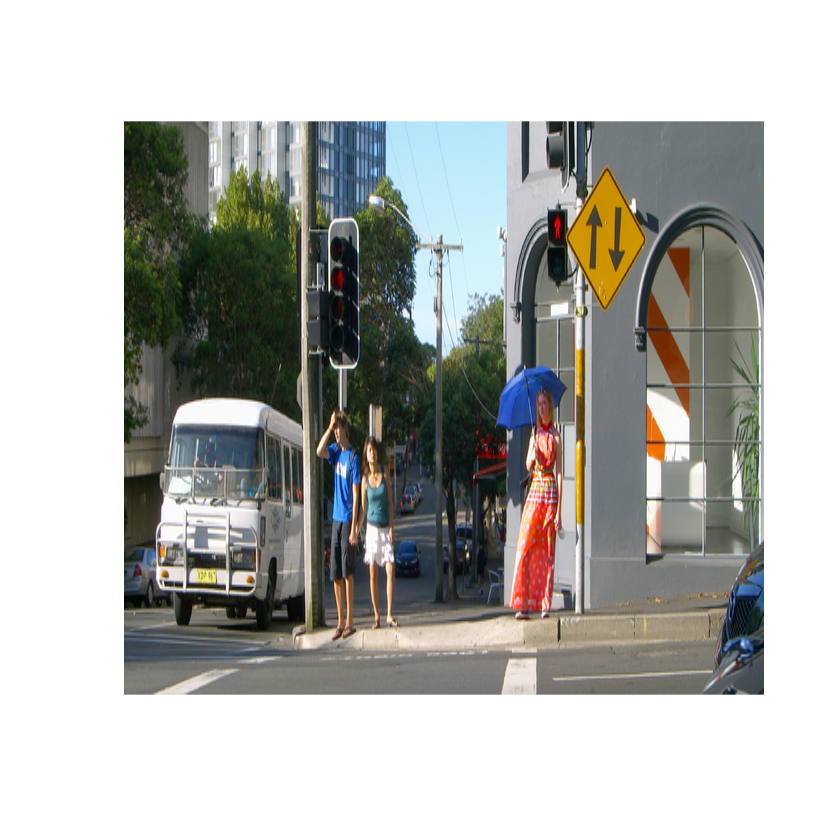

In [44]:
if (!("jpeg" %in% rownames(installed.packages()))) {install.packages("jpeg")}

plot(c(0,1), c(0,1), type="n",
     ann=FALSE, axes=FALSE)

rasterImage(draw/255, 
            xleft=0, ybottom=0, 
            xright=1, ytop=1)

### Testing the neural network

Unfortunately there are limits to how much reticulate can replicate of a Python script in R. In this case we cannot draw the bounding boxes on the image because the Python functions do not return an object, as R requires, but they modify the object itself in a separate environment that R cannot have access to. We will therefore limit to providing the information about all the boxes located by the RetineNet in the image.

In [11]:
K <- backend()
image <- retinanet$utils$image$read_image_bgr("640px-Woman_with_blue_parasol_at_intersection.png")

print(dim(image))

draw <- image
channel_1 <- draw[,,1]
channel_3 <- draw[,,3]
draw[,,1] <- channel_3
draw[,,3] <- channel_1

image <- retinanet$utils$image$preprocess_image(image)
scaled_image <- retinanet$utils$image$resize_image(image)
image <- scaled_image[[1]]
scale <- scaled_image[[2]]

print(dim(image))

[1] 313 640   3
[1]  652 1333    3


In [12]:
predictions <- model$predict_on_batch(k_expand_dims(image, axis=1))

In [13]:
boxes <- predictions[[1]]
scores <- predictions[[2]]
labels <- predictions[[3]]

In [45]:
print(paste("image size is", paste(dim(draw), collapse=',')))

for (el in 1:length(scores)) {
    if (scores[el] > 0.5) {
        
        box <- as.integer(c(boxes[el*4-3], boxes[el*4-2], boxes[el*4-1], boxes[el*4])/scale) 
        print(paste("detected", labels_to_names(labels[el]), 
                    "at position", paste(box, collapse=','),
                    "with confidence", round(scores[el], 2)))
        
        color <- retinanet$utils$colors$label_color(as.integer(labels[el]))
        retinanet$utils$visualization$draw_caption(draw, box, 
                                                   labels_to_names(labels[el]))
        retinanet$utils$visualization$draw_box(draw, box, color=color)
    }
}

[1] "image size is 313,640,3"
[1] "detected umbrella at position 371,423,190,202 with confidence 0.93"
[1] "detected traffic light at position 233,271,387,273 with confidence 0.91"
[1] "detected person at position 0,352,325,579 with confidence 0.9"
[1] "detected traffic light at position 421,34,211,332 with confidence 0.88"
[1] "detected person at position 31,601,362,362 with confidence 0.87"
[1] "detected car at position 350,181,318,79 with confidence 0.78"
[1] "detected person at position 333,449,375,115 with confidence 0.78"
[1] "detected car at position 579,283,346,129 with confidence 0.73"
[1] "detected car at position 194,332,70,232 with confidence 0.71"
[1] "detected person at position 220,271,332,405 with confidence 0.67"
[1] "detected car at position 429,349,180,0 with confidence 0.64"
[1] "detected car at position 351,375,579,334 with confidence 0.61"
[1] "detected traffic light at position 114,224,421,422 with confidence 0.6"
[1] "detected bus at position 351,221,373,386 wit